In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
from contractions import contractions_dict
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [3]:
entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')
business = pd.read_csv('data/BBCNewsSummaryCSV/business_data.csv')
politics = pd.read_csv('data/BBCNewsSummaryCSV/politics_data.csv')

In [4]:
training_dataset = pd.concat([entertainment,sport,tech], ignore_index=True)
testing_dataset = pd.concat([business,politics], ignore_index=True)

In [5]:
print("Training size:",training_dataset.size)
print("Testing size:",testing_dataset.size)

Training size: 3894
Testing size: 2781


In [6]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)
testing_dataset = testing_dataset.sample(frac=1).reset_index(drop=True)

In [7]:
training_dataset['newsarticle'] = training_dataset['newsarticle'].apply(expand_contractions)
testing_dataset['newsarticle'] = testing_dataset['newsarticle'].apply(expand_contractions)

In [8]:
def getSenLen(sentence):
    return len(sentence.split())

In [9]:
training_dataset['article_length'] = training_dataset['newsarticle'].apply(getSenLen)
training_dataset['summary_length'] = training_dataset['summary'].apply(getSenLen)
testing_dataset['article_length'] = testing_dataset['newsarticle'].apply(getSenLen)
testing_dataset['summary_length'] = testing_dataset['summary'].apply(getSenLen)


In [10]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,entertainment_113,Wal-Mart is sued over rude lyrics\n\nThe paren...,Wal-Mart said it was investigating the claims ...,240,98
1,tech_304,Format wars could confuse users\n\nTechnology ...,"Instead, said Mr Doctorow, DRM systems were in...",730,312
2,entertainment_087,Global release for Japan hit film\n\nOscar-win...,Oscar-winning animator Hayao Miyazaki's latest...,174,64
3,entertainment_081,Oscars race enters final furlong\n\nThe race f...,The only people who will know the Oscar winner...,317,139
4,entertainment_130,Charity single for quake relief\n\nSingers inc...,He said the song was a slow ballad and would w...,363,135


In [11]:
training_dataset.describe()

,article_length,summary_length
count,1298.000000,1298.000000
mean,385.013097,165.270416
std,243.616315,109.734916
min,115.000000,42.000000
25%,235.000000,99.250000
50%,323.000000,137.000000
75%,465.750000,202.750000
max,3540.000000,1706.000000


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

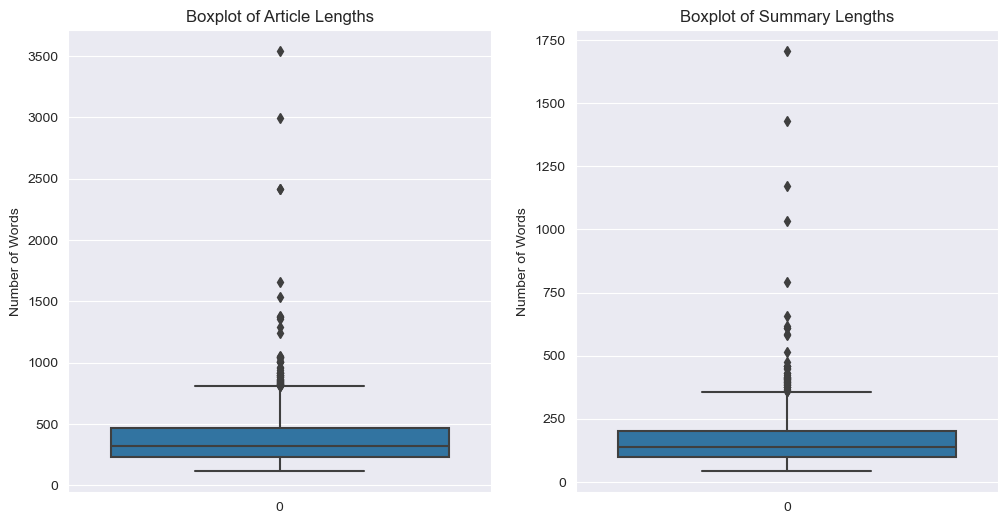

In [12]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the articles' number of words
sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

# Plot for the summaries' number of words
sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")


In [13]:
# Get statistics for the articles boxplot
lines_articles = axes[0].lines[:6]
articles_stats = [line.get_ydata()[0] for line in lines_articles]
Q1_articles, Q3_articles, lower_whisker_articles, upper_whisker_articles, median_articles = articles_stats[:5]

# Get statistics for the summaries boxplot
lines_summaries = axes[1].lines[:6]
summaries_stats = [line.get_ydata()[0] for line in lines_summaries]
Q1_summaries, Q3_summaries, lower_whisker_summaries, upper_whisker_summaries, median_summaries = summaries_stats[:5]

In [14]:
print(upper_whisker_articles)
print(upper_whisker_summaries)

810.0
355.0


In [15]:
training_dataset = training_dataset[(training_dataset['summary_length'] <= upper_whisker_summaries) & (training_dataset['article_length'] <= upper_whisker_articles)]
testing_dataset = testing_dataset[(testing_dataset['summary_length'] <= upper_whisker_summaries) & (testing_dataset['article_length'] <= upper_whisker_articles)]

In [16]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,entertainment_113,Wal-Mart is sued over rude lyrics\n\nThe paren...,Wal-Mart said it was investigating the claims ...,240,98
1,tech_304,Format wars could confuse users\n\nTechnology ...,"Instead, said Mr Doctorow, DRM systems were in...",730,312
2,entertainment_087,Global release for Japan hit film\n\nOscar-win...,Oscar-winning animator Hayao Miyazaki's latest...,174,64
3,entertainment_081,Oscars race enters final furlong\n\nThe race f...,The only people who will know the Oscar winner...,317,139
4,entertainment_130,Charity single for quake relief\n\nSingers inc...,He said the song was a slow ballad and would w...,363,135


In [17]:
training_dataset.describe()

,article_length,summary_length
count,1240.000000,1240.000000
mean,351.926613,150.501613
std,156.300192,67.456332
min,115.000000,42.000000
25%,233.000000,97.000000
50%,315.000000,133.500000
75%,441.000000,190.000000
max,810.000000,354.000000


In [18]:
df = training_dataset[1:100]

In [19]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

In [20]:
# Define the device for GPU usage (if available)
if torch.backends.mps.is_available():
    arch = "mps"
elif torch.cuda.is_available():
    arch = "cuda"
else:
    arch = "cpu"

device = torch.device(arch)

In [21]:
# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU

def tokenize_and_stack(df, text_column, summary_column):
    df['TokenizedText'] = df[text_column].apply(tokenize_text)
    df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)
    
    # Convert tokenized data to PyTorch tensors
    X = torch.stack([seq.squeeze() for seq in df['TokenizedText']])
    Y = torch.stack([seq.squeeze() for seq in df['TokenizedSummary']])
    
    # Define a DataLoader for batching data
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    return X, Y, dataloader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize and stack for training set
X_train, Y_train, train_dataloader = tokenize_and_stack(train_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_val, Y_val, val_dataloader = tokenize_and_stack(val_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_test, Y_test, test_dataloader = tokenize_and_stack(testing_dataset, 'newsarticle', 'summary')



# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU


df['TokenizedText'] = df['newsarticle'].apply(tokenize_text)
df['TokenizedSummary'] = df['summary'].apply(tokenize_summary)

# Split your data into train and test sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert tokenized data to PyTorch tensors
X_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedText']])
Y_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedSummary']])
X_val = torch.stack([seq.squeeze() for seq in eval_df['TokenizedText']])
Y_val = torch.stack([seq.squeeze() for seq in eval_df['TokenizedSummary']])

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = TensorDataset(X_val, Y_val)
val_dataloader = DataLoader(val_dataset, batch_size=4)


In [23]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
model.to(device)  # Move the model to the GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0

# Define gradient accumulation steps
accumulation_steps = 20  # You can adjust this number


/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:124: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [24]:
def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [25]:
# Training loop
for epoch in range(2):  # Change the number of epochs as needed
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")

model.save_pretrained("saved_model")

Training:   0%|          | 0/20 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Epoch 1/2, Train Loss: 0.6404


Training: 100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epoch 2/2, Train Loss: 0.6501


def calculate_rouge1_precision(logits, targets):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    rouge1_precision = 0.0
    num_samples = len(logits)

    for i in range(num_samples):
        predicted_ids = logits[i].cpu().numpy()
        target_ids = targets[i].cpu().numpy()

        # Convert token IDs to strings
        predicted_text = tokenizer.decode(predicted_ids, skip_special_tokens=True)
        target_text = tokenizer.decode(target_ids, skip_special_tokens=True)

        # Calculate ROUGE-1 precision
        scores = scorer.score(predicted_text, target_text)
        rouge1_precision += scores['rouge1'].precision

    return rouge1_precision / num_samples


In [58]:
def evaluate(model, dataloader):
    model.eval()
    
    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)
                
                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores

# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores = evaluate(model, val_dataloader)

# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-1 Precision': rouge1_precision_scores,
}

# Create a Pandas DataFrame from the dictionary
results_df = pd.DataFrame(data)

# Display the DataFrame
pd.set_option('display.max_colwidth', None)
results_df.head(5)

Evaluating Test:  20%|██        | 1/5 [09:48<39:15, 588.76s/it]


KeyboardInterrupt: 

In [56]:
results_df['Article'][1]

'summarize: Hotspot users gain free net calls\n\nPeople using wireless net hotspots will soon be able to make free phone calls as well as surf the net.\n\nWireless provider Broadreach and net telephony firm Skype are rolling out a service at 350 hotspots around the UK this week. Users will need a Skype account - downloadable for free - and they will then be able to make net calls via wi-fi without paying for net access. Skype allows people to make free PC-based calls to other Skype users.\n\nUsers of the system can also make calls to landlines and mobiles for a fee. The system is gaining in popularity and now has 28 million users around the world. Its paid service - dubbed Skype Out - has so far attracted 940,000 users. It plans to add more paid services with forthcoming launches of video conferencing, voice mail and Skype In, a service which would allow users to receive phone calls from landlines and mobiles. London-based software developer Connectotel has unveiled software that will 

In [57]:
len(results_df['Actual Summary'][1])

602

In [54]:

results_df['Predicted Summary'][1]

'summarize: Hotspot users gain free net calls to other Skype users. Players of the system can also make $$$$ as well as surf the net with a $1,000, $2, $3, $4, $5, $6, $7, $8, $10, $11, $9, $12, $1 and $24, $16, $25 and net telephony firm Skype are rolling out a service at 350 hotspots around the UK this week. Users will need a Skype account - downloadable for free - and they will then be able to make net calls via wi-fi without paying for net access. Skype allows people to make free PC-based calls to'

In [ ]:
# get_ipython().system('jupyter nbconvert --to script BART-Base.ipynb')


In [23]:
from rouge_score import rouge_scorer

def evaluate(model, dataloader):
    model.eval()
    
    all_predicted_summaries = []
    all_actual_summaries = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target in zip(outputs, targets):
                # Convert token IDs to strings
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)

                all_predicted_summaries.append(output_text)
                all_actual_summaries.append(target_text)

    # Calculate ROUGE-1 precision for all predictions
    rouge1_precision = calculate_rouge1_precision(all_predicted_summaries, all_actual_summaries)

    return rouge1_precision

def calculate_rouge1_precision(predictions, targets):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    rouge1_precision = 0.0
    num_samples = len(predictions)

    for i in range(num_samples):
        predicted_text = predictions[i]
        target_text = targets[i]

        scores = scorer.score(predicted_text, target_text)
        rouge1_precision += scores['rouge1'].precision

    return rouge1_precision / num_samples


In [24]:
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset
from transformers import BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from nltk.tokenize import sent_tokenize
import numpy as np
from scipy import spatial
import networkx as nx
from rouge_score import rouge_scorer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import re
from torch.cuda.amp import autocast, GradScaler

# Assuming you have already defined your train_dataloader, test_dataloader, and other necessary components

# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0
evaluation_interval = 1  # Evaluate every epoch in this example, adjust as needed

# Define gradient accumulation steps
accumulation_steps = 20  # You can adjust this number

# Training loop with continuous evaluation and model saving
for epoch in range(2):  # Change the number of epochs as needed
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    # Print average training loss for the epoch
    print(f"Epoch {epoch+1}/{2}, Train Loss: {total_loss / len(train_dataloader):.4f}")

    # Continuous evaluation at specified intervals
    if (epoch + 1) % evaluation_interval == 0:
        rouge1_precision = evaluate(model, val_dataloader)
        print(f"Epoch {epoch+1}/{2}, ROUGE-1 Precision: {rouge1_precision:.4f}")

        # Save the best model
        if rouge1_precision > best_rouge_score:
            best_rouge_score = rouge1_precision
            current_round = 0
            # Save the model checkpoint
            model.save_pretrained("best_model_checkpoint")
        else:
            current_round += 1

        # Early stopping logic (if needed)
        if current_round >= early_stopping_rounds:
            print("Early stopping! The model performance is not improving.")
            break

# Load the best model for testing
best_model = BartForConditionalGeneration.from_pretrained("best_model_checkpoint")
# Now you can use this best_model for testing


/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:124: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/kysgattu/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/20 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


Epoch 1/2, Train Loss: 0.6416


Evaluating: 100%|██████████| 5/5 [02:57<00:00, 35.57s/it]


Epoch 1/2, ROUGE-1 Precision: 0.4256


Training:   0%|          | 0/20 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


Epoch 2/2, Train Loss: 0.6448


Evaluating: 100%|██████████| 5/5 [02:59<00:00, 35.97s/it]


Epoch 2/2, ROUGE-1 Precision: 0.4256


# Assuming you have already defined your test_dataloader and other necessary components

# Load the best model for testing
# best_model = BartForConditionalGeneration.from_pretrained("best_model_checkpoint")
best_model.to(device)  # Move the model to the GPU if available

# Testing function
def test(model, dataloader):
    model.eval()
    
    all_predicted_summaries = []
    all_actual_summaries = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target in zip(outputs, targets):
                # Convert token IDs to strings
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)

                all_predicted_summaries.append(output_text)
                all_actual_summaries.append(target_text)

    # Calculate ROUGE-1 precision for all predictions
    rouge1_precision = calculate_rouge1_precision(all_predicted_summaries, all_actual_summaries)

    print(f"ROUGE-1 Precision on Test Set: {rouge1_precision:.4f}")



# Call the testing function
test(best_model, test_dataloader)

In [34]:
def generate_summary(text, loader_model):
    # Tokenize the input text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=150, truncation=True, padding='max_length', return_attention_mask=True)

    # Generate summary using the loaded model
    with torch.no_grad():
        summary_ids = loaded_model.generate(inputs, max_length=512, num_beams=17, length_penalty=2.0, early_stopping=False)

    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [42]:
input_text = training_dataset['newsarticle'][2]

In [43]:
loaded_model = BartForConditionalGeneration.from_pretrained("saved_model")
# tokenizer = BartTokenizer.from_pretrained("best_model_checkpoint")

In [44]:
input_text

'Zambia confident and cautious\n\nZambias technical director, Kalusha Bwalya is confident and cautious ahead of the Cosafa Cup final against Angola on Saturday in Lusaka.\n\nBwalya said: "Nothing short of victory will do." However Bwalya warned his side not to be too complacent. "I do not want my team to be too comfortable or too sure of victory as it is going to be a difficult game. "For me the main aim of the game is to enjoy and to win." Zambia have shown their determination to win this final by recalling nine of their foreign-based players. However the 41 year-old Bwalya, who became the oldest player to appear in the competition when he played and scored against Mauritius, is uncertain whether he will take to the field or not. The Chipolopolo fans however are not being so cautious with a victory concert already scheduled for after the match featuring some of the countrys top musicians. Both sides are hoping to win the competition for a record third time, and so keep the trophy for 

In [45]:
len(input_text)

1555

In [46]:
generated_summary = generate_summary(input_text,loaded_model)

In [47]:
len(generated_summary)

735

In [48]:
print("Generated Summary:", generated_summary)

Generated Summary: summarize: Zambia confident and cautious ahead of Cosafa Cup finalZambias technical director, Kalusha Bwalya says Zambia have nothing short of victory as they prepare to face Angola on Saturday in Lusaka. Zambia will face Angola in the Cosafa World Cup final on Saturday.Zambia's technical directorKALUSA BWALYABWalya said: "Nothing short of margin of victory will do." However Bwalaa warned his side not to be too complacent. "I do not want my team to betoo comfortable or too sure of victory, as it is going to be a difficult game. "For me the main aim of the game is to enjoy and to win." Zambians have shown their determination to win this final by recalling nine of their foreign-based players. However the 41 year-old Bwalea, who
